# Predicting Premium (Regression)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt 

sb.set()

insurance_data = pd.read_csv("train.csv")

# One hot encoding to treat categorical variables
y = insurance_data['Annual_Premium']
X = pd.DataFrame(insurance_data[["Age","Response"]])
one_hot_data = pd.get_dummies(insurance_data[['Previously_Insured','Vehicle_Age', 'Vehicle_Damage', "Policy_Sales_Channel"]],drop_first=True)
X = pd.concat([X, one_hot_data.set_index(X.index)], axis=1)

#Train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25,random_state = 420)
train_set = pd.concat([X_train,y_train],axis=1)
test_set = pd.concat([X_test,y_test],axis=1)

#Removing outlier
q3 = train_set['Annual_Premium'].quantile(q=0.75)
q1 = train_set['Annual_Premium'].quantile(q=0.25)
iqr = q3-q1
max_limit = q3+1.5*iqr
min_limit = q1-1.5*iqr
train_set = train_set.loc[(train_set['Annual_Premium']>min_limit)&(train_set['Annual_Premium']<max_limit)]
test_set = test_set.loc[(test_set['Annual_Premium']>min_limit)&(test_set['Annual_Premium']<max_limit)]

#Feature scaling for KMeans
from sklearn.preprocessing import StandardScaler
scalr = StandardScaler().fit(train_set[['Age','Policy_Sales_Channel']])
train_set[['Age','Policy_Sales_Channel']] = scalr.transform(train_set[['Age','Policy_Sales_Channel']])
test_set[['Age','Policy_Sales_Channel']] = scalr.transform(test_set[['Age','Policy_Sales_Channel']])

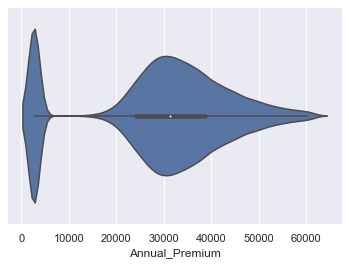

In [2]:
#Visualisation of Output before KMeans
sb.violinplot(x=train_set['Annual_Premium'])
plt.show()

In [3]:
#KMeans 
from sklearn.cluster import KMeans
km = KMeans(n_clusters=3).fit(train_set)
train_set['type'] = km.predict(train_set)
test_set['type'] = km.predict(test_set)
train_set.groupby(by=['type'],axis=0).mean()

,Age,Response,Previously_Insured,Policy_Sales_Channel,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years,Vehicle_Damage_Yes,Annual_Premium
type,,,,,,,,
0,0.140422,0.130134,0.366190,0.032599,0.324390,0.041821,0.581326,2782.883780
1,-0.165314,0.107344,0.517183,0.116892,0.520209,0.025692,0.446975,29572.673377
2,0.218455,0.143576,0.409584,-0.234998,0.349398,0.067479,0.559374,44906.809793


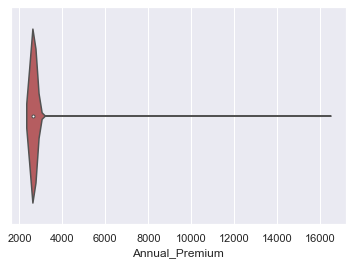

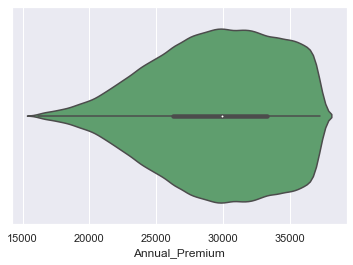

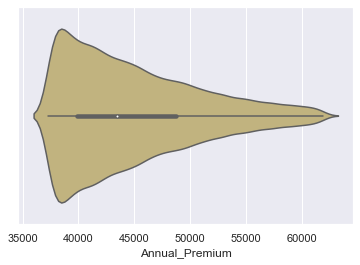

In [11]:
#Visualisation of Output after KMeans
for i in range(3):
    sb.violinplot(x = train_set.loc[train_set.type==i]['Annual_Premium'],color=['r','g','y'][i])
    plt.show()

In [5]:
#Feature engineering
train_set['Vehicle_Age'] = 0.5-(train_set['Vehicle_Age_< 1 Year'])/2+(train_set['Vehicle_Age_> 2 Years']/2)
test_set['Vehicle_Age'] = 0.5-(test_set['Vehicle_Age_< 1 Year'])/2+(test_set['Vehicle_Age_> 2 Years']/2)

#Selecting Response = 1
y_train = train_set.loc[(train_set.Response==1)]['Annual_Premium']
X_train = train_set.loc[(train_set.Response==1)].drop(['Response','Annual_Premium','Vehicle_Age_< 1 Year','Vehicle_Age_> 2 Years'],axis=1)
y_test = test_set.loc[(test_set.Response==1)]['Annual_Premium']
X_test = test_set.loc[(test_set.Response==1)].drop(['Response','Annual_Premium','Vehicle_Age_< 1 Year','Vehicle_Age_> 2 Years'],axis=1)

# 5 approachs for Linear Regression
1. LinearRegression
2. DecisionTreeRegressor
3. RandomForestRegressor
4. TransformedTargetRegressor
5. MLPRegressor

In [6]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import QuantileTransformer
from sklearn.compose import TransformedTargetRegressor
import xgboost as xg

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error


dt = DecisionTreeRegressor()
reg = LinearRegression()
rf = RandomForestRegressor()
tr = TransformedTargetRegressor(regressor=xg.XGBRFRegressor(), transformer=QuantileTransformer(output_distribution='normal'))
nn = MLPRegressor(hidden_layer_sizes=(6,6,),solver='lbfgs',activation='relu',max_iter=10000)


for model in [dt,reg,rf,tr,nn]:
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    print(r2_score(y_test, y_pred), np.sqrt(mean_squared_error(y_test, y_pred)))

0.8953660328585787 5044.175444140053
0.8718108760447563 5583.1516910044675
0.9014260068176457 4895.927890928363
0.9082757544136906 4722.760388308678
0.9083160625035694 4721.722569095529


In [7]:
pd.DataFrame(np.array([y_test,y_pred]).T,columns=['Test','Predicted']).head(10)

,Test,Predicted
0,24363.0,29837.748173
1,2630.0,2830.744424
2,2630.0,2703.243747
3,2630.0,2702.788151
4,19466.0,30256.015052
5,18198.0,30331.095468
6,23670.0,30331.095468
7,48872.0,46061.574847
8,2630.0,2681.927443
9,33277.0,30341.126178


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:title={'center':'Response = 1'}, xlabel='Predicted', ylabel='Test'>

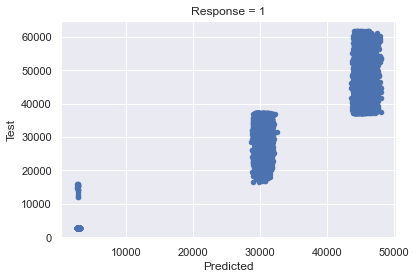

In [8]:
scatter_df = pd.DataFrame(np.array([y_test,y_pred]).T,columns=['Test','Predicted'])
scatter_df.plot.scatter(x='Predicted',y='Test',title='Response = 1')

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


0.8975502539409022 4686.392136970212


<AxesSubplot:title={'center':'Response = 0'}, xlabel='Predicted', ylabel='Test'>

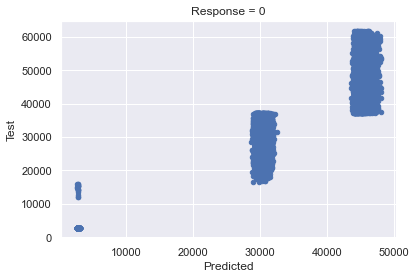

In [9]:
y0_train = train_set.loc[(train_set.Response==0)]['Annual_Premium']
X0_train = train_set.loc[(train_set.Response==0)].drop(['Response','Annual_Premium','Vehicle_Age_< 1 Year','Vehicle_Age_> 2 Years'],axis=1)
y0_test = test_set.loc[(test_set.Response==0)]['Annual_Premium']
X0_test = test_set.loc[(test_set.Response==0)].drop(['Response','Annual_Premium','Vehicle_Age_< 1 Year','Vehicle_Age_> 2 Years'],axis=1)

tr = TransformedTargetRegressor(regressor=xg.XGBRFRegressor(), transformer=QuantileTransformer(output_distribution='normal'))
tr.fit(X0_train,y0_train)
y0_pred = tr.predict(X0_test)
print(r2_score(y0_test, y0_pred), np.sqrt(mean_squared_error(y0_test, y0_pred)))

scatter0_df = pd.DataFrame(np.array([y_test,y_pred]).T,columns=['Test','Predicted'])
scatter0_df.plot.scatter(x='Predicted',y='Test',title='Response = 0')

# Conclusion
No difference between pricing between response = 0 and 1, meaning that company is using same pricing mechanism for both groups. Using first part, we can accurately classify into response = 0 or 1, then we should apply different pricing mechanism for the response = 0 to convert them into response = 1. Ultimately, data given is limited and more data on customer background is required for further analysis